In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
large_dataset = np.load('data/large_dataset.npy')
small_dataset = np.load('data/small_dataset.npy')
small_labels = np.load('data/small_dataset_labels.npy').astype(int)

In [4]:
class KMeans(object):
    def __init__(self, K):
        self.K = K
        self.losses = []

    def euclidean_distance(self, x1, x2):
        if x1.shape != x2.shape:
            print("Dimension mismatch when calculating euclidean distances")
        return np.sqrt(np.sum((x1 - x2) ** 2))

    def fit(self, X):
        # Generate initial clusters
        N = X.shape[0]
        D = X.shape[1]
        clusters_index = []
        while len(clusters_index) < self.K:
            rand_index = np.random.randint(0, N)
            if rand_index not in clusters_index:
                clusters_index.append(rand_index)
        clusters = np.array([X[i] for i in clusters_index])
        
        # Iniitialize cluster assignments
        cluster_assignments = np.empty(N, dtype=int)
        
        # Clear losses
        self.losses = []
        
        # Begin fitting
        while True:
            # Assign new clusters
            new_cluster_assignments = np.empty(N, dtype=int)
            for index in range(N):
                current = X[index]
                min_cluster = None
                min_dist = float('inf')
                for i, c in enumerate(clusters):
                    dist = self.euclidean_distance(current, c)
                    if dist < min_dist:
                        min_dist = dist
                        min_cluster = i
                new_cluster_assignments[index] = min_cluster
            if (new_cluster_assignments==cluster_assignments).all():
                break
            cluster_assignments = new_cluster_assignments
            
            # Update cluster centers
            totals = np.zeros((self.K, D))
            counts = np.zeros(self.K, dtype=int)
            for index in range(N):
                cluster = cluster_assignments[index]
                totals[cluster] += X[index]
                counts[cluster] += 1
            new_clusters = []
            for j in range(self.K):
                new_clusters.append(totals[j] / counts[j])
            clusters = new_clusters
            
            # Calculate loss
            current_loss = 0
            for index in range(N):
                current = X[index]
                cluster = clusters[cluster_assignments[index]]
                temp = current - cluster
                current_loss += np.dot(temp, temp)
            self.losses.append(current_loss)
        
        self.clusters = clusters
        self.cluster_assignments = cluster_assignments
        
    def get_mean_images(self):
        return self.clusters
    
    def plot_loss(self):
        plt.figure()
        plt.plot(self.losses)
        plt.xlabel('Iterations')
        plt.ylabel('Loss')
        plt.show()

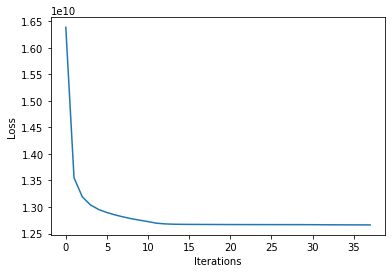

In [4]:
# 2.1
KMeansClassifier = KMeans(K=10)
KMeansClassifier.fit(large_dataset)
KMeansClassifier.plot_loss()

In [5]:
# 2.2
# K = [5, 10, 20]
# avg = []
# std = []

# for k in K:
#     classifier = KMeans(K=k)
#     final_loss = []
#     for iter in range(5):
#         classifier.fit(large_dataset)
#         final_loss.append(classifier.losses[-1])
#     avg.append(np.mean(final_loss))
#     std.append(np.std(final_loss))

# plt.figure()
# plt.errorbar(K, avg, yerr=std, linestyle='none', marker='o', markersize=2.0, ecolor='red')
# plt.xlabel('K')
# plt.ylabel('Final Objective Value')
# plt.show()

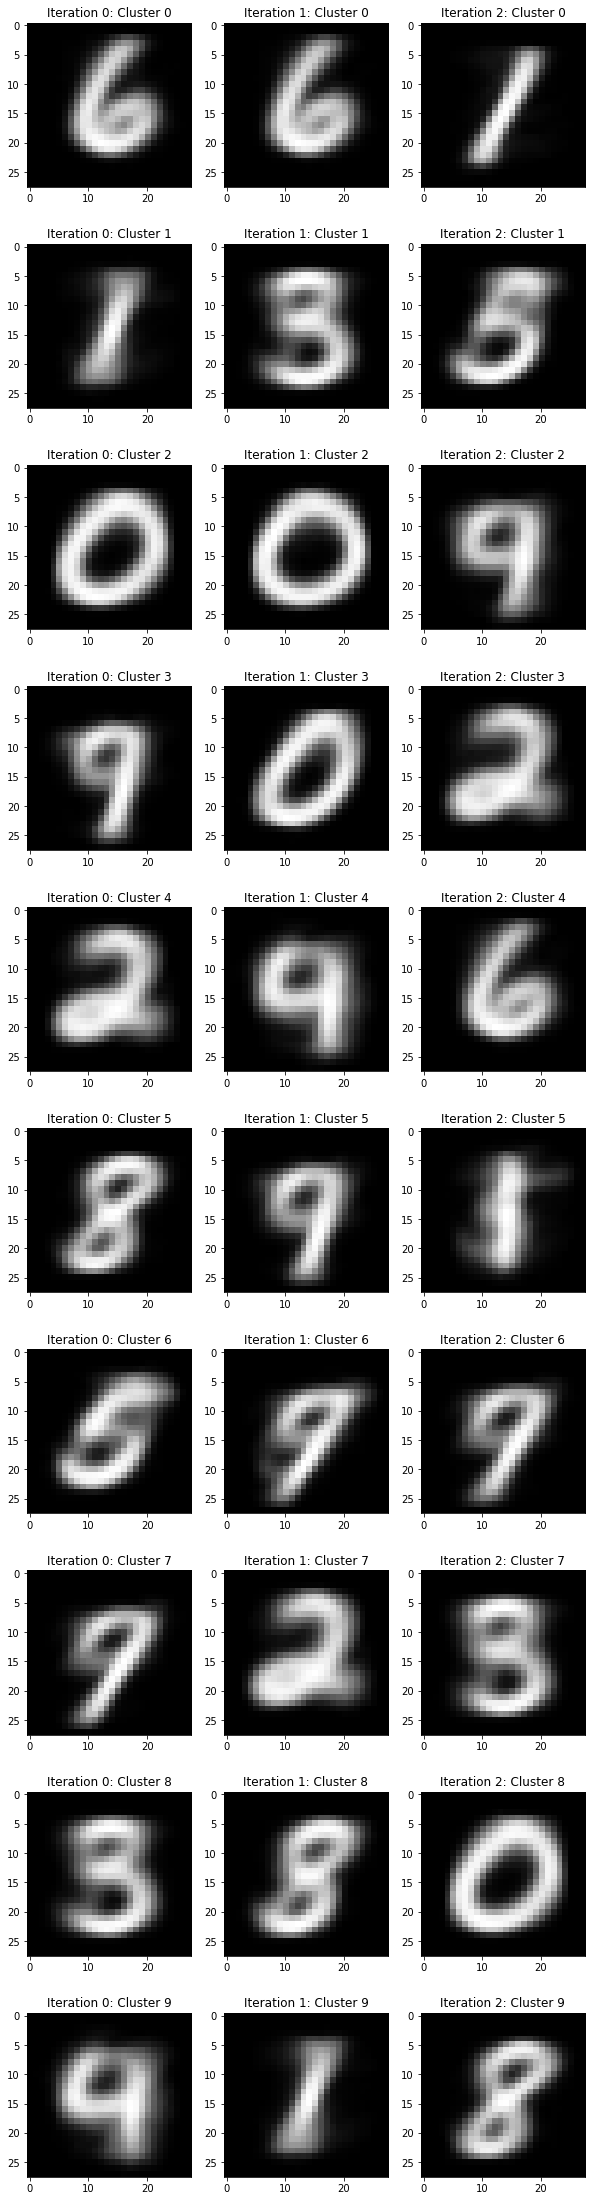

In [6]:
# 2.3
KMeansClassifier = KMeans(K=10)
KMeansClassifier.fit(large_dataset)
clusters1 = KMeansClassifier.get_mean_images()
KMeansClassifier.fit(large_dataset)
clusters2 = KMeansClassifier.get_mean_images()
KMeansClassifier.fit(large_dataset)
clusters3 = KMeansClassifier.get_mean_images()

clusters_list = [clusters1, clusters2, clusters3]

fig, axs = plt.subplots(10, 3, figsize=(10, 40))
for i in range(10):
    for j in range(3):
        axs[i, j].imshow(clusters_list[j][i].reshape(28,28), cmap='Greys_r')
        axs[i, j].set_title(f'Iteration {j}: Cluster {i}')

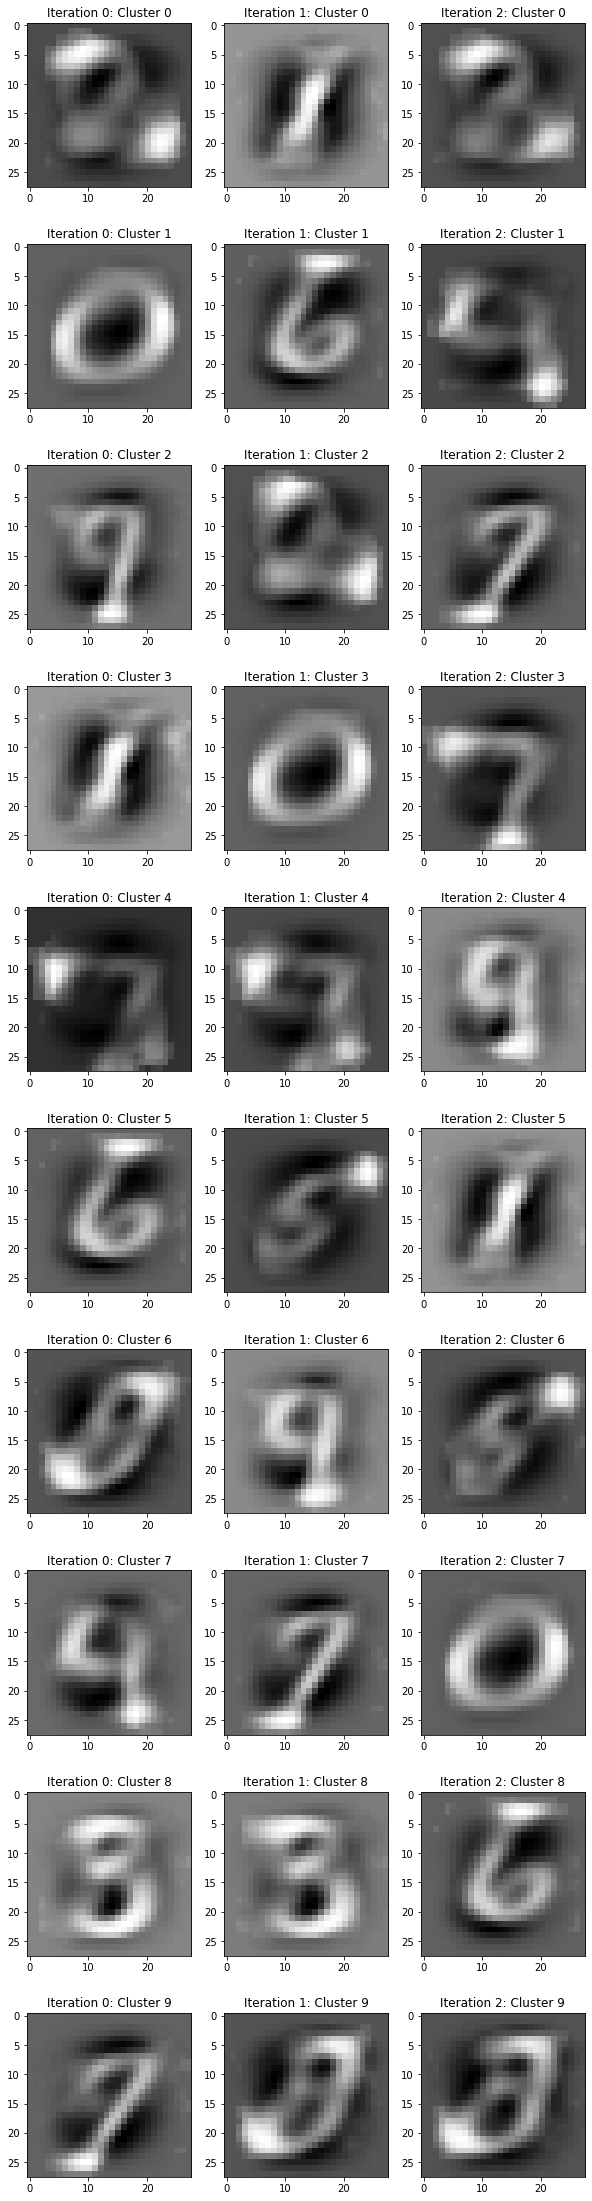

In [7]:
# 2.4
normalized_data = []
for j in range(large_dataset.shape[1]):
    data = large_dataset[:, j]
    mean = np.mean(data)
    std = np.std(data)
    if std == 0:
        normalized_data.append(data / 1)
    else:
        normalized_data.append((data - mean) / std)
normalized_data = np.transpose(np.array(normalized_data))  

KMeansClassifier = KMeans(K=10)
KMeansClassifier.fit(normalized_data)
clusters1 = KMeansClassifier.get_mean_images()
KMeansClassifier.fit(normalized_data)
clusters2 = KMeansClassifier.get_mean_images()
KMeansClassifier.fit(normalized_data)
clusters3 = KMeansClassifier.get_mean_images()

clusters_list = [clusters1, clusters2, clusters3]

fig, axs = plt.subplots(10, 3, figsize=(10, 40))
for i in range(10):
    for j in range(3):
        axs[i, j].imshow(clusters_list[j][i].reshape(28,28), cmap='Greys_r')
        axs[i, j].set_title(f'Iteration {j}: Cluster {i}')

In [8]:
import itertools
from scipy.spatial import distance

class HAC(object):
    def __init__(self, K, linkage):
        self.K = K
        self.linkage = linkage
    
    def distance(self, c1, c2):
        # Get distances
        distances = distance.cdist(c1, c2, 'euclidean')
        
        # Figure out what to return
        if self.linkage == 'min':
            return np.min(distances)
        elif self.linkage == 'max':
            return np.max(distances)
        else:
            return np.linalg.norm(np.mean(c1, axis=0) - np.mean(c2, axis=0))
    
    def fit(self, X):
        N = X.shape[0]
        D = X.shape[1]
        clusters = [{i} for i in range(N)]
        
        self.merge_distances = []
        
        while len(clusters) > self.K:
            min_dist_between_clusters = float('inf')
            min_cluster_1 = None
            min_cluster_2 = None
            for c1, c2 in itertools.combinations(clusters, 2):
                # Transform indices to actual data points
                cluster1 = np.array([X[index] for index in c1])
                cluster2 = np.array([X[index] for index in c2])
                dist = self.distance(cluster1, cluster2)
                if dist < min_dist_between_clusters:
                    min_dist_between_clusters = dist
                    min_cluster_1 = c1
                    min_cluster_2 = c2
            self.merge_distances.append(min_dist_between_clusters)
            # Merge the clusters with the smallest distance between them
            clusters.remove(min_cluster_1)
            clusters.remove(min_cluster_2)
            clusters.append(min_cluster_1.union(min_cluster_2))
            
        self.clusters = clusters
        
    def get_mean_images(self):
        return self.clusters

In [9]:
minHACifier = HAC(K=10, linkage='min')
minHACifier.fit(small_dataset)
clusters1 = minHACifier.get_mean_images()
maxHACifier = HAC(K=10, linkage='max')
maxHACifier.fit(small_dataset)
clusters2 = maxHACifier.get_mean_images()
centroidHACifier = HAC(K=10, linkage='centroid')
centroidHACifier.fit(small_dataset)
clusters3 = centroidHACifier.get_mean_images()

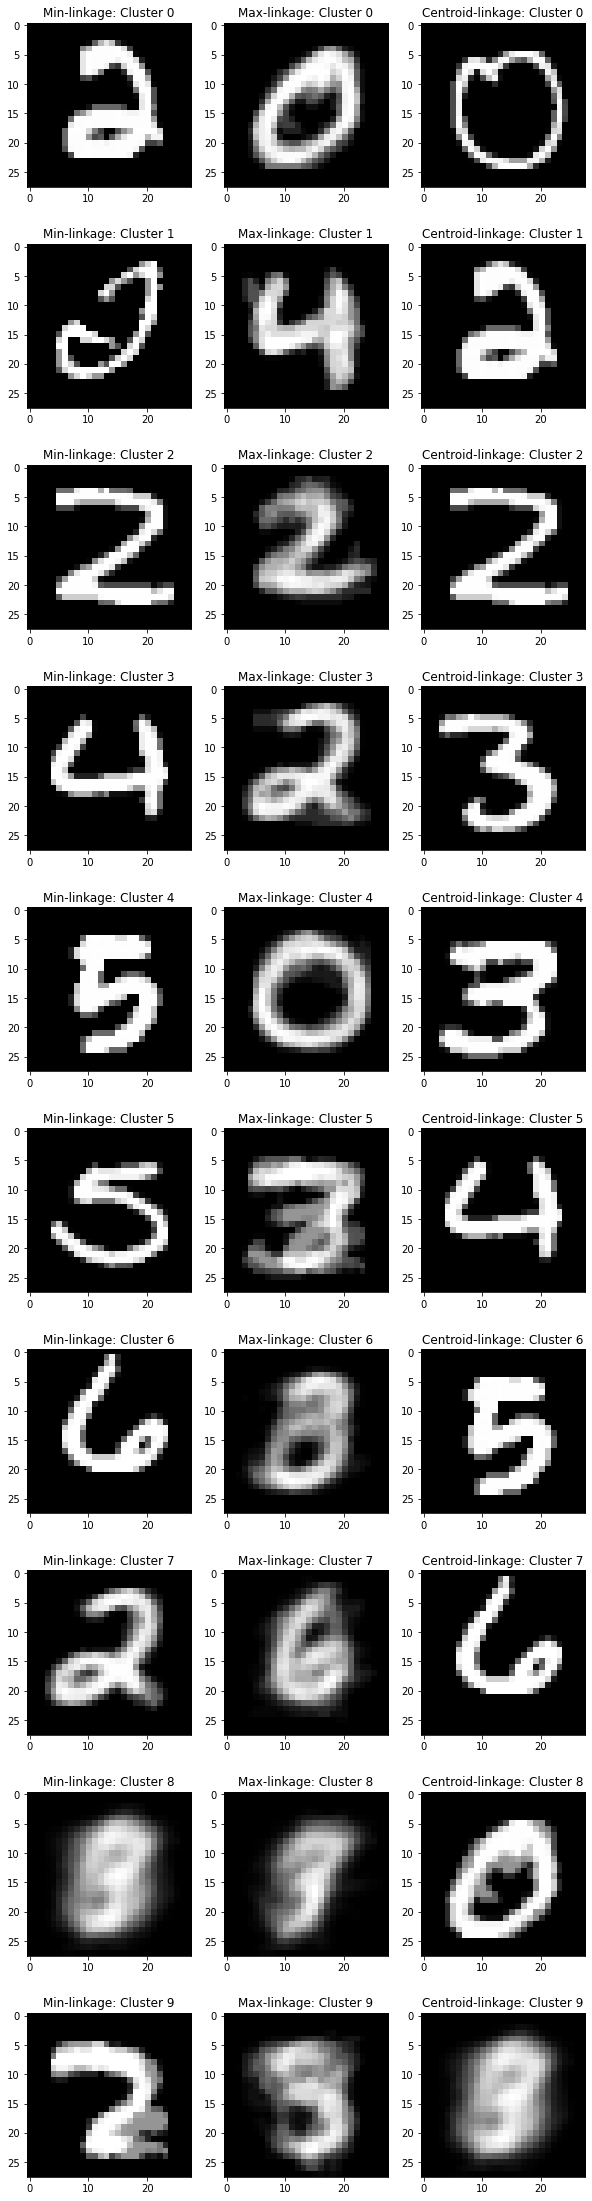

In [10]:
# 2.5
clusters_list = [clusters1, clusters2, clusters3]
clusters_titles = ['Min', 'Max', 'Centroid']
fig, axs = plt.subplots(10, 3, figsize=(10, 40))
for i in range(10):
    for j in range(3):
        cluster = clusters_list[j][i]
        cluster = np.mean(np.array([small_dataset[c] for c in cluster]), axis=0)
        axs[i, j].imshow(cluster.reshape(28,28), cmap='Greys_r')
        axs[i, j].set_title(f'{clusters_titles[j]}-linkage: Cluster {i}')

[Text(0, 0.5, 'Most recent distance'), Text(0.5, 0, 'Merges completed')]

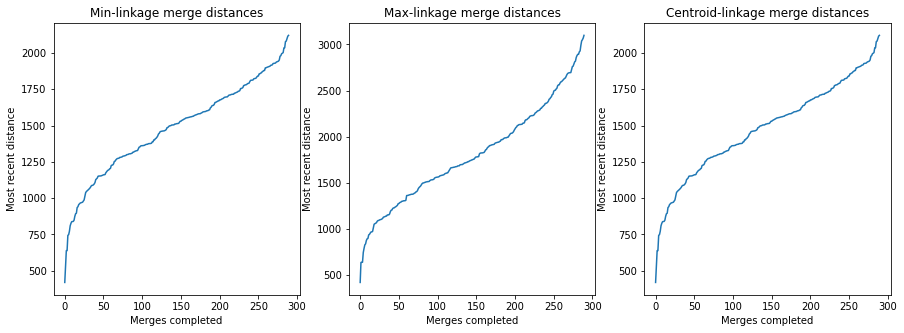

In [11]:
# 2.6
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
ax1.plot(minHACifier.merge_distances)
ax1.set_title('Min-linkage merge distances')
ax1.set(xlabel="Merges completed", ylabel="Most recent distance")
ax2.plot(maxHACifier.merge_distances)
ax2.set_title('Max-linkage merge distances')
ax2.set(xlabel="Merges completed", ylabel="Most recent distance")
ax3.plot(minHACifier.merge_distances)
ax3.set_title('Centroid-linkage merge distances')
ax3.set(xlabel="Merges completed", ylabel="Most recent distance")

[Text(0, 0.5, 'Number of images in cluster'), Text(0.5, 0, 'Cluster index')]

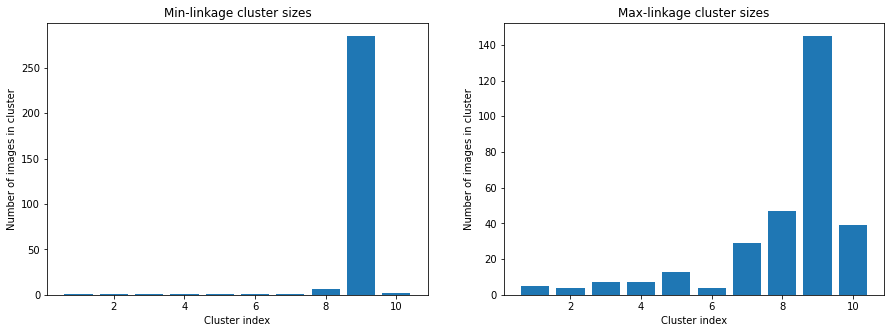

In [12]:
# 2.7
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.bar(np.arange(1, 11), [len(cluster) for cluster in minHACifier.clusters])
ax1.set_title('Min-linkage cluster sizes')
ax1.set(xlabel="Cluster index", ylabel="Number of images in cluster")
ax2.bar(np.arange(1, 11), [len(cluster) for cluster in maxHACifier.clusters])
ax2.set_title('Max-linkage cluster sizes')
ax2.set(xlabel="Cluster index", ylabel="Number of images in cluster")

In [5]:
# 2.8
import seaborn as sns

smallKMeansClassifier = KMeans(K=10)
smallKMeansClassifier.fit(small_dataset)

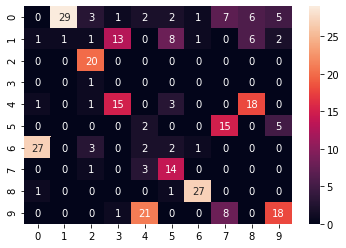

In [7]:
confusion_matrix = np.zeros((10, 10))
for index in range(len(smallKMeansClassifier.cluster_assignments)):
    i = smallKMeansClassifier.cluster_assignments[index]
    j = small_labels[index]
    confusion_matrix[i][j] += 1
sns.heatmap(confusion_matrix, annot=True)

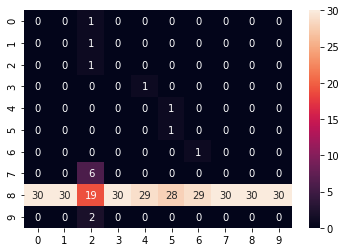

In [21]:
confusion_matrix = np.zeros((10, 10))
for i in range(10):
    for image in minHACifier.clusters[i]:
        j = small_labels[image]
        confusion_matrix[i][j] += 1
sns.heatmap(confusion_matrix, annot=True)

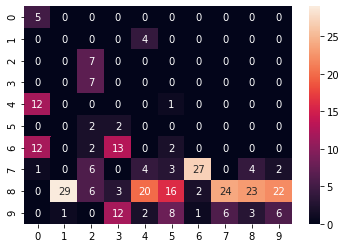

In [22]:
confusion_matrix = np.zeros((10, 10))
for i in range(10):
    for image in maxHACifier.clusters[i]:
        j = small_labels[image]
        confusion_matrix[i][j] += 1
sns.heatmap(confusion_matrix, annot=True)

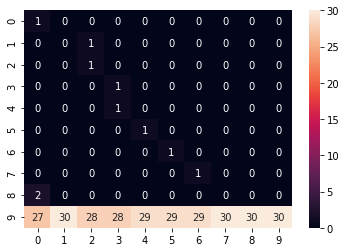

In [23]:
confusion_matrix = np.zeros((10, 10))
for i in range(10):
    for image in centroidHACifier.clusters[i]:
        j = small_labels[image]
        confusion_matrix[i][j] += 1
sns.heatmap(confusion_matrix, annot=True)